Urban Data Science & Smart Cities <br>
URSP688Y <br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

[<img src="https://colab.research.google.com/assets/colab-badge.svg"> Clean version](https://colab.research.google.com/github/ncsg/ursp688y_sp2024/blob/main/demos/demo11/demo11.ipynb)

[<img src="https://colab.research.google.com/assets/colab-badge.svg"> Modified in class](https://colab.research.google.com/drive/1SK47cU6k9u9iE8LmH5rtDVnz2eIlghDP?usp=sharing)

# Demo 11 - Spatial Visualization

In [119]:
# Everything depends on matplotlib under the hood
import matplotlib.pyplot as plt

In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Set the working directory
# # You will need to change this to your own folder on Google Drive
# os.chdir('/content/drive/MyDrive/Teaching/URSP688Y Spring 2024/demos/week10')

## GeoPandas

The simplest option

In [2]:
import geopandas as gpd

In [105]:
crs = 26918 # UTM18
affordable_housing = gpd.read_file('affordable_housing.geojson').to_crs(crs)
tracts = gpd.read_file('dc_tracts.geojson').to_crs(crs)

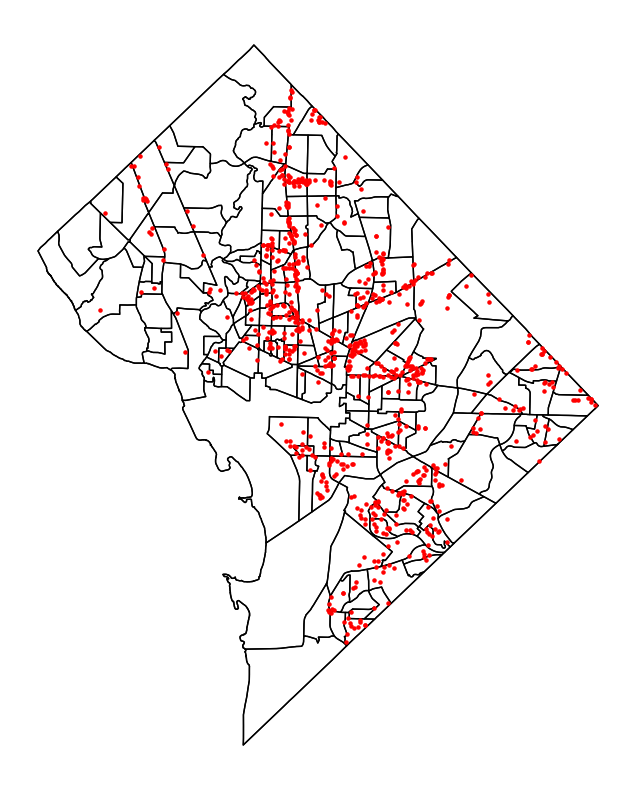

In [118]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = tracts.plot(ax=ax, facecolor='none', edgecolor='k', zorder=0)
affordable_housing.plot(ax=ax, markersize=5, color='r', zorder=1)
ax.axis('off')

plt.savefig('large_scale_map.eps')

plt.show()

## Folium

Interactive web-style maps with on [Leaflet.js](https://leafletjs.com/reference)

In [121]:
# !pip install folium

In [120]:
import folium

In [201]:
affordable_housing = gpd.read_file('affordable_housing.geojson')
tracts = gpd.read_file('dc_tracts.geojson')

# Project into lat and long (WGS84)
affordable_housing = affordable_housing.to_crs(4326)
tracts = tracts.to_crs(4326)

# Drop column with timestamps because they interfere with Folium
affordable_housing = affordable_housing.drop(columns=['GIS_LAST_MOD_DTTM'])

# Identify map center
lon_min, lat_min, lon_max, lat_max = tracts.total_bounds
lon_center = (lon_max + lon_min) / 2
lat_center = (lat_max + lat_min) / 2

# Initiate map
map = folium.Map(location=(lat_center, lon_center), zoom_start=12)
# map = folium.Map(location=(lat_center, lon_center), zoom_start=12, tiles="Cartodb Positron")

# Add tracts
folium.GeoJson(data=tracts.to_json(), fillColor='#00000000', color='black', weight=1).add_to(map)

# Add affordable housing points
circle_marker = folium.CircleMarker(radius = 4, weight = 1, color='white', fillColor = 'darkblue', fill_opacity=1)
affordable_housing_points = folium.GeoJson(affordable_housing.to_json(), marker=circle_marker)
folium.features.GeoJsonPopup(fields=['PROJECT_NAME','TOTAL_AFFORDABLE_UNITS'], labels=True).add_to(affordable_housing_points)
affordable_housing_points.add_to(map)

map

## CartoPy

Good for smaller-scale maps with sophisticated projections and built-in reference layers

In [3]:
# !pip install cartopy

In [25]:
import cartopy.crs as ccrs
import cartopy.feature as creature

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


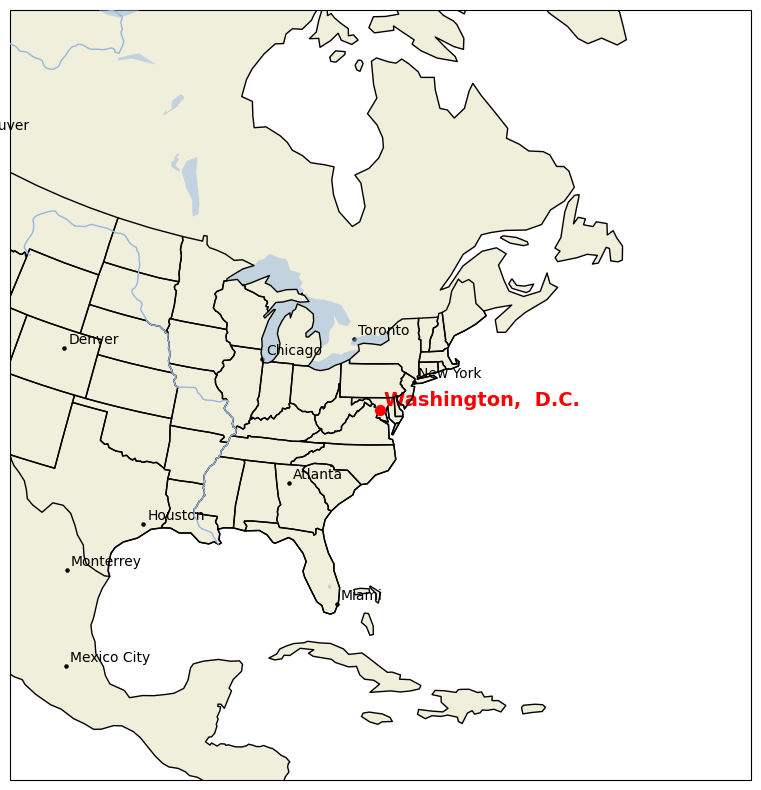

In [100]:
# Define highlight city
highlight_city = 'Washington,  D.C.'
# highlight_city = 'Chicago'

# Load city points
pop_places = gpd.read_file('ne_10m_populated_places_simple.zip')

# Define map center and extents around the highlight city
lon_center = pop_places[pop_places['name'] == highlight_city].geometry.x.iloc[0]
lat_center = pop_places[pop_places['name'] == highlight_city].geometry.y.iloc[0]
extent = 50
lon_min = lon_center + (extent / 2)
lon_max = lon_center - (extent / 2)
lat_min = lat_center - (extent / 2)
lat_max = lat_center + (extent / 2)

# Define projection centered on highlight city
crs = ccrs.AzimuthalEquidistant(central_longitude=dc_center_lon, central_latitude=dc_center_lat)

# Project cities into axis coordinate system
pop_places = pop_places.to_crs(crs.proj4_init)

# Constrain to cities only one rank lower than the highlight
rank = pop_places[pop_places['name'] == highlight_city].scalerank.iloc[0] + 1
pop_places = pop_places[pop_places.scalerank <= rank]

# Initiate figure
fig = plt.figure(figsize=(15, 10))

# Initiate axis with defined projection
ax = plt.subplot(1, 1, 1, projection=crs)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add base features
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='blue', linestyle='--', zorder=0)
ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.COASTLINE, zorder=2)
ax.add_feature(cfeature.LAKES, alpha=0.5, zorder=3)
ax.add_feature(cfeature.STATES, zorder=4)
ax.add_feature(cfeature.RIVERS, zorder=5)

# Add city points
pop_places.plot(ax=ax, markersize=5, color='k', zorder=1)
pop_places[pop_places['name'] == highlight_city].plot(ax=ax, markersize=50, color='r', zorder=6)

# Label cities
def annotate(record):
    if record['name'] == highlight_city:
        ax.annotate(record['name'], weight='bold', size=14, color='red', xy=record.geometry.coords[0], xytext=(3, 3), textcoords='offset points', clip_on=True)
    else:
        ax.annotate(record['name'], xy=record.geometry.coords[0], xytext=(3, 3), textcoords='offset points', clip_on=True)
pop_places.apply(annotate, axis=1)

plt.savefig('small scale map.eps', format='eps')

plt.show()